In [294]:
from tsdiff.models.epsnet.dualenc_dimepp_newedge_nolocal import DualEncoderEpsNetwork
import yaml
from easydict import EasyDict
import torch
import pickle
import tqdm
import itertools
import numpy as np
import matplotlib.pyplot as plt

In [5]:
with open("/home/ksh/MolDiff/tsdiff/configs/job_coff10.0_edge3_ReLU_128_5.yml","r") as f:
    config = EasyDict(yaml.safe_load(f))
model = DualEncoderEpsNetwork(config.model)

In [40]:
with open("data/TS/b97d3/raw_data/b97d3_reactants.txt", "r") as f:
    r_xyz = f.readlines()
with open("data/TS/b97d3/raw_data/b97d3_products.txt", "r") as f:
    p_xyz = f.readlines()
    
r_xyz = "".join(r_xyz).split("$$$$$")[:-1]
for i, xyz in enumerate(r_xyz):
    xyz = torch.Tensor([[float(u) for u in l.split("\t")[1:]] for l in xyz.strip().split("\n")[2:]])
    r_xyz[i] = xyz
    
p_xyz = "".join(p_xyz).split("$$$$$")[:-1]
for i, xyz in enumerate(p_xyz):
    xyz = torch.Tensor([[float(u) for u in l.split("\t")[1:]] for l in xyz.strip().split("\n")[2:]])
    p_xyz[i] = xyz
    


In [41]:
with open("data/TS/b97d3/random_split3/index_list.pkl","rb") as f:
    idx_list = pickle.load(f)
with open("data/TS/b97d3/random_split3/train_data.pkl","rb") as f:
    train = pickle.load(f)
with open("data/TS/b97d3/random_split3/val_data.pkl","rb") as f:
    val = pickle.load(f)
with open("data/TS/b97d3/random_split3/test_data.pkl","rb") as f:
    test = pickle.load(f)

In [42]:
idx = idx_list["train_index"]
r_xyz = [r_xyz[i] for i in idx] + [r_xyz[i] for i in idx_list["valid_index"]] + [r_xyz[i] for i in idx_list["test_index"]]
p_xyz = [p_xyz[i] for i in idx] + [p_xyz[i] for i in idx_list["valid_index"]] + [p_xyz[i] for i in idx_list["test_index"]]
data = train + val + test
for d, r, p in zip(data, r_xyz, p_xyz):
    d.r_pos = r
    d.p_pos = p

In [51]:
d = data[0]
print(d)
N = len(d.atom_type)
pos = d.pos
bond_index = d.edge_index
bond_type = d.edge_type
batch = torch.Tensor([0]*N).to(torch.long)

edge_idx, _, type_r, type_p = model._extend_condensed_graph_edge(N, pos, bond_index, bond_type, batch, edge_order=3, cutoff=0.1)

Data(atom_type=[9], edge_index=[2, 22], edge_type=[22], p_feat=[9, 25], p_pos=[9, 3], pos=[9, 3], r_feat=[9, 25], r_pos=[9, 3], rdmol=[2], smiles="[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8])[H:9]>>[C:1]1([H:7])([H:8])/[C:2](=[N:3]\[H:9])[N:6]1[N:5]=[O:4]")


In [130]:

d_dict_r_ts = dict([(x, []) for x in list(itertools.product(range(25), range(25)))])
d_dict_p_ts = dict([(x, []) for x in list(itertools.product(range(25), range(25)))])
d_dict_mid_ts = dict([(x, []) for x in list(itertools.product(range(25), range(25)))])

for d in tqdm.tqdm(data):
    # get edge index and edge type
    N = len(d.atom_type)
    pos = d.pos
    bond_index = d.edge_index
    bond_type = d.edge_type
    batch = torch.Tensor([0]*N).to(torch.long)
    edge_idx, _, type_r, type_p = model._extend_condensed_graph_edge(N, pos, bond_index, bond_type, batch, edge_order=3, cutoff=0.1)
    
    # distance of each edge in r,p,ts geometry
    ts_dm = torch.cdist(d.pos, d.pos)
    r_dm = torch.cdist(d.r_pos, d.r_pos)
    p_dm = torch.cdist(d.p_pos, d.p_pos)
    r_d = []
    p_d = []
    ts_d = []
    for i in range(edge_idx.shape[1]):
        r_d.append(r_dm[edge_idx[0][i]][edge_idx[1][i]])
        p_d.append(p_dm[edge_idx[0][i]][edge_idx[1][i]])
        ts_d.append(ts_dm[edge_idx[0][i]][edge_idx[1][i]])
    r_d = torch.Tensor(r_d)
    p_d = torch.Tensor(p_d)
    ts_d = torch.Tensor(ts_d)
    
    # append distance error of r geometry for each edge type
    for er, ep, emid, r, p in zip(r_d - ts_d, p_d - ts_d, 0.5*r_d + 0.5*p_d - ts_d, type_r, type_p):
        x = d_dict_r_ts[(r.item(), p.item())]
        x.append(er)
        
        x = d_dict_p_ts[(r.item(), p.item())]
        x.append(ep)
        
        x = d_dict_mid_ts[(r.item(), p.item())]
        x.append(emid)

100%|██████████| 32680/32680 [06:18<00:00, 86.28it/s] 


/home/ksh/.conda/envs/tsdiff/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice.
  if __name__ == '__main__':


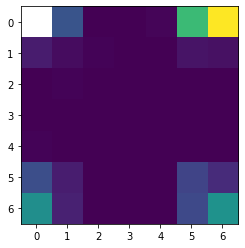

In [257]:
converter = np.arange(25)
converter[12] = 4
converter[23] = 5
converter[24] = 6
nonzero_idx = np.array([ 0,  1,  2,  3, 12, 23, 24])
X = np.zeros((7,7))
for k, v in d_dict_r_ts.items():
    if k[0] in nonzero_idx and k[1] in nonzero_idx:
        X[converter[k[0]], converter[k[1]]] = np.abs(np.array(v)).mean()

converter = np.arange(25)
converter[12] = 4
converter[23] = 5
converter[24] = 6
nonzero_idx = np.array([ 0,  1,  2,  3, 12, 23, 24])
rX = np.zeros((7,7))
for k, v in d_dict_r_ts.items():
    if k[0] in nonzero_idx and k[1] in nonzero_idx:
        rX[converter[k[0]], converter[k[1]]] = len(v)
rX = rX / rX.sum()
#plt.imshow(rX)
#plt.imshow(X)
plt.imshow(X*rX)

/home/ksh/.conda/envs/tsdiff/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice.
  if __name__ == '__main__':


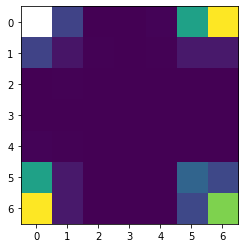

In [258]:
converter = np.arange(25)
converter[12] = 4
converter[23] = 5
converter[24] = 6
nonzero_idx = np.array([ 0,  1,  2,  3, 12, 23, 24])
X = np.zeros((7,7))
for k, v in d_dict_mid_ts.items():
    if k[0] in nonzero_idx and k[1] in nonzero_idx:
        X[converter[k[0]], converter[k[1]]] = np.abs(np.array(v)).mean()

converter = np.arange(25)
converter[12] = 4
converter[23] = 5
converter[24] = 6
nonzero_idx = np.array([ 0,  1,  2,  3, 12, 23, 24])
rX = np.zeros((7,7))
for k, v in d_dict_mid_ts.items():
    if k[0] in nonzero_idx and k[1] in nonzero_idx:
        rX[converter[k[0]], converter[k[1]]] = len(v)
rX = rX / rX.sum()
#plt.imshow(rX)
#plt.imshow(X)
plt.imshow(X*rX)

In [176]:
with open("logs/train_ts_dv3_newedge_nolocal_zzin-retrain_zzin-retrain/sample_ld_result3000/samples_all.pkl",'rb') as f:
    gen_data = pickle.load(f)

In [291]:

d_dict_gen_ts = dict([(x, []) for x in list(itertools.product(range(25), range(25)))])
edge_nums = []
for d in tqdm.tqdm(gen_data):
    # get edge index and edge type
    N = len(d.atom_type)
    pos = d.pos
    bond_index = d.edge_index
    bond_type = d.edge_type
    batch = torch.Tensor([0]*N).to(torch.long)
    edge_idx, _, type_r, type_p = model._extend_condensed_graph_edge(N, pos, bond_index, bond_type, batch, edge_order=2, cutoff=5.0)
    
    edge_nums.append((edge_idx.shape[1]/2, N))
    # distance of each edge in r,p,ts geometry
    ts_dm = torch.cdist(d.pos, d.pos)
    gen_dm = torch.cdist(d.pos_gen, d.pos_gen)
    gen_d = []
    ts_d = []
    for i in range(edge_idx.shape[1]):
        gen_d.append(gen_dm[edge_idx[0][i]][edge_idx[1][i]])
        ts_d.append(ts_dm[edge_idx[0][i]][edge_idx[1][i]])
    gen_d = torch.Tensor(gen_d)
    ts_d = torch.Tensor(ts_d)
    
    # append distance error of r geometry for each edge type
    for egen, r, p in zip(gen_d - ts_d, type_r, type_p):
        x = d_dict_gen_ts[(r.item(), p.item())]
        x.append(egen)


100%|██████████| 3000/3000 [00:21<00:00, 142.04it/s]


In [292]:
e, n = torch.LongTensor(edge_nums).T
(e - 3*n + 6)[tmp < 1]

tensor([15, 15, 10, 10,  6,  6,  6,  6,  6,  6, 20, 20,  8,  8, 43, 43, 28, 28,
        27, 27, 19, 19, 15, 15, 36, 36, 15, 15, 26, 26, 26, 26, 34, 34, 27, 27,
        25, 25, 21, 21,  9,  9, 25, 25,  9,  9, 21, 21, 28, 28, 61, 61, 42, 42,
        15, 15, 36, 36, 36, 36, 28, 28, 10, 10, 21, 21, 27, 27, 26, 26, 21, 21,
         6,  6,  9,  9, 52, 52, 21, 21, 14, 14, 53, 53, 34, 34, 35, 35, 64, 64,
        57, 57, 72, 72, 82, 82, 19, 19, 21, 21, 19, 19, 20, 20, 41, 41, 34, 34,
        61, 61, 75, 75, 38, 38, 44, 44, 43, 43, 14, 14, 10, 10, 49, 49, 41, 41,
        26, 26, 14, 14, 55, 55, 28, 28, 44, 44, 42, 42, 63, 63, 21, 21, 27, 27,
        43, 43, 21, 21, 21, 21, 16, 16, 73, 73, 36, 36])

In [290]:
tmp = torch.Tensor([x/(3*y -6) for x, y in edge_nums])
(tmp < 1).float().mean()
torch.LongTensor(edge_nums)[tmp < 1]
pass

/home/ksh/.conda/envs/tsdiff/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice.
  if __name__ == '__main__':
/home/ksh/.conda/envs/tsdiff/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


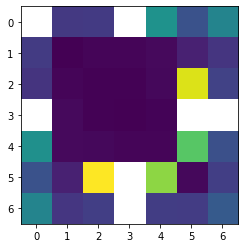

In [240]:
converter = np.arange(25)
converter[12] = 4
converter[23] = 5
converter[24] = 6
nonzero_idx = np.array([ 0,  1,  2,  3, 12, 23, 24])
X = np.zeros((7,7))
for k, v in d_dict_gen_ts.items():
    if k[0] in nonzero_idx and k[1] in nonzero_idx:
        X[converter[k[0]], converter[k[1]]] = np.abs(np.array(v)).mean()
    
plt.imshow(X)

tensor([[    0.00,     0.90,     0.00,     0.00,     0.06,     3.41,     7.31],
        [    0.90,    15.11,     0.74,     0.03,     0.33,     0.80,     0.49],
        [    0.00,     0.74,     0.43,     0.11,     0.20,     0.00,     0.01],
        [    0.00,     0.03,     0.11,     0.17,     0.03,     0.00,     0.00],
        [    0.06,     0.33,     0.20,     0.03,     0.12,     0.01,     0.01],
        [    3.41,     0.80,     0.00,     0.00,     0.01,    26.72,     2.41],
        [    7.31,     0.49,     0.01,     0.00,     0.01,     2.41,    23.76]])


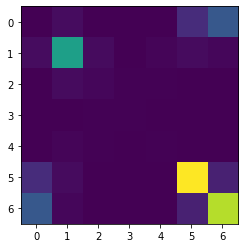

In [268]:
converter = np.arange(25)
converter[12] = 4
converter[23] = 5
converter[24] = 6
nonzero_idx = np.array([ 0,  1,  2,  3, 12, 23, 24])
rX = np.zeros((7,7))
for k, v in d_dict_gen_ts.items():
    if k[0] in nonzero_idx and k[1] in nonzero_idx:
        rX[converter[k[0]], converter[k[1]]] = len(v)
#rX = rX / rX.sum()
plt.imshow(rX/rX.sum())
rX = torch.Tensor(rX)
rX = rX / rX.sum()
torch.set_printoptions(precision=2,sci_mode=False)
print(rX*100)

/home/ksh/.conda/envs/tsdiff/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice.
  if __name__ == '__main__':


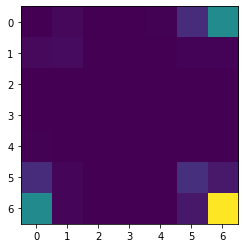

In [259]:
converter = np.arange(25)
converter[12] = 4
converter[23] = 5
converter[24] = 6
nonzero_idx = np.array([ 0,  1,  2,  3, 12, 23, 24])
X = np.zeros((7,7))
for k, v in d_dict_gen_ts.items():
    if k[0] in nonzero_idx and k[1] in nonzero_idx:
        X[converter[k[0]], converter[k[1]]] = np.abs(np.array(v)).mean()
    
converter = np.arange(25)
converter[12] = 4
converter[23] = 5
converter[24] = 6
nonzero_idx = np.array([ 0,  1,  2,  3, 12, 23, 24])
rX = np.zeros((7,7))
for k, v in d_dict_gen_ts.items():
    if k[0] in nonzero_idx and k[1] in nonzero_idx:
        rX[converter[k[0]], converter[k[1]]] = len(v)
rX = rX / rX.sum()

plt.imshow(np.nan_to_num(X * rX))